![LangGraph 플로우](./langgraph_flow.png)

In [1]:
import operator
from typing import TypedDict, List, Dict, Any, Optional, Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import Annotated
import pandas as pd
import json

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage, ChatMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import START, END
from langgraph.graph import StateGraph
from langchain.agents import create_tool_calling_agent, create_react_agent, AgentExecutor
from langchain.agents.format_scratchpad import format_log_to_messages
from langchain_experimental.tools import PythonREPLTool
from uuid import uuid4

from agent_config import AgentConfig
from data import DBManager
from utils import *
from tools import *
from prompts import Prompt
import builtins
# 

import os
os.environ["PYDANTIC_STRICT_SCHEMA_VALIDATION"] = "False"

%load_ext autoreload
%autoreload 2

/Users/iminhyeong/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/langchain_experimental/tools/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_experimental.tools.python.tool import PythonAstREPLTool, PythonREPLTool
/Users/iminhyeong/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:775: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `PythonREPL` to V2.
  war

In [3]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv()
logging.langsmith("Agent-LangGraph-Test")

LangSmith 추적을 시작합니다.
[프로젝트명]
Agent-LangGraph-Test


In [4]:
# LLM 모델 설정
MODEL_NAME = "gpt-4o"  # 또는 다른 모델 이름 사용
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 설정 및 DB 연결
conf = AgentConfig()
dbm = DBManager(conf)
db = dbm.get_db_connection()

# 상태 모델 정의

In [5]:
class DBState(BaseModel):
    # 대화 히스토리
    messages: List[Dict[str, Any]] = Field(default_factory=list)
    question: Optional[str] = None
    
    # 각 도구의 출력
    selected_tables: Dict[str, str] = Field(default_factory=dict)
    generated_queries: Dict[str, str] = Field(default_factory=dict)
    df_dict: Dict[str, Any] = Field(default_factory=dict)
    python_code: Optional[str] = None
    final_result: Optional[str] = None
    result_df: Optional[Any] = None
    
    # 상태 관리
    status: str = "running"
    error: Optional[Dict[str, Any]] = None
    
    # 중간 단계 기록
    intermediate_steps: List[Dict[str, Any]] = Field(default_factory=list)

    # config
    conf: Optional[Any] = Field(default=None, exclude=True)  # AgentConfig
    dbm: Optional[Any] = Field(default=None, exclude=True)  # DBManager
    db: Optional[Any] = Field(default=None, exclude=True)  # DB Connection
    
    # class Config:
    #     arbitrary_types_allowed = True

    # Pydantic v2 방식
    model_config = {
        "arbitrary_types_allowed": True,
        "json_encoders": {
            pd.DataFrame: lambda _: "<DataFrame>"
        }
    }
    
    def model_dump(self, **kwargs):
        """DataFrame 등을 제외하고 직렬화하는 메서드"""
        data = super().model_dump(**kwargs)
        # DataFrame 관련 필드 제거
        if 'df_dict' in data:
            data.pop('df_dict')
        if 'result_df' in data:
            data.pop('result_df')
        return data

# 노드 정의

In [6]:
def table_selector_node(state: DBState) -> Dict[str, Any]:
    """
    테이블 선택 노드: 사용자 쿼리를 분석하여 관련된 데이터베이스 테이블을 선택합니다.
    """
    # 메시지에서 질문 추출
    if state.messages:
        last_message = state.messages[-1]
        question = last_message.get("content", "")
    else:
        return {**state.model_dump(), "error": {"message": "메시지가 없습니다."}, "status": "error"}
    
    try:
        # 도구 정의
        tools = [select_table]
        
        # 프롬프트 생성
        table_selector_prompt = Prompt().table_selector_prompt()
        
        llm_for_agent = ChatOpenAI(model=MODEL_NAME, temperature=0)

        # 에이전트 생성
        agent = create_tool_calling_agent(llm_for_agent, tools=tools, prompt=table_selector_prompt)
        agent_executor = AgentExecutor(
            agent=agent,
            tools=tools,
            handle_parsing_errors=True,
            verbose=True
        )
        
        # 메시지 형식 변환
        messages_for_agent = []
        for msg in state.messages:
            if msg.get("role") == "user" or msg.get("role") == "human":
                messages_for_agent.append({"role": "user", "content": msg.get("content", "")})
            elif msg.get("role") == "assistant" or msg.get("role") == "ai":
                messages_for_agent.append({"role": "assistant", "content": msg.get("content", "")})
            elif msg.get("role") == "system":
                messages_for_agent.append({"role": "system", "content": msg.get("content", "")})
        
        # 에이전트 실행
        result = agent_executor.invoke({
            "question": question,
            "messages": messages_for_agent,
            "tools": ", ".join([t.name for t in tools]),
            "tool_names": ", ".join([t.name for t in tools])
        })
        
        # 결과 처리
        selected_tables = json_parse(result["output"])
        
        # 상태 업데이트
        new_state = state.model_dump()
        new_state["selected_tables"] = selected_tables
        new_state["question"] = question
        
        # 메시지 추가
        assistant_message = {"role": "assistant", "content": "테이블 선택을 완료했습니다."}
        tool_message = {
            "role": "tool", 
            "content": result["output"],
            "name": "select_table",
            "tool_call_id": str(uuid4())
        }
        new_state["messages"] = state.messages + [assistant_message, tool_message]
        
        return new_state
    
    except Exception as e:
        # 오류 처리
        return {
            **state.model_dump(),
            "error": {"message": str(e)},
            "status": "error"
        }

In [7]:
def query_generator_node(state: DBState) -> Dict[str, Any]:
    """
    쿼리 생성 노드: 테이블 선택 결과를 바탕으로 SQL 쿼리를 생성합니다.
    """
    # 상태 확인
    if not state.selected_tables:
        return {**state.model_dump(), "error": {"message": "선택된 테이블이 없습니다."}, "status": "error"}
    
    question = state.question if state.question else ""
    selected_tables = state.selected_tables
    db = state.db
    
    try:
        builtins.db = db
        
        # 도구 정의
        tools = [generate_sql_query]
        
        # 프롬프트 생성
        query_generator_prompt = Prompt().query_generator_prompt()
        
        # 에이전트 생성
        agent = create_tool_calling_agent(llm, tools=tools, prompt=query_generator_prompt)
        agent_executor = AgentExecutor(
            agent=agent,
            tools=tools,
            handle_parsing_errors=True,
            verbose=True
        )
        
        # 선택된 테이블 형식화
        tables_formatted = format_tables_for_prompt(selected_tables)
        selected_tables_json = json.dumps(selected_tables, indent=2)
        
        # 메시지 형식 변환
        messages_for_agent = []
        for msg in state.messages:
            if msg.get("role") == "user" or msg.get("role") == "human":
                messages_for_agent.append({"role": "user", "content": msg.get("content", "")})
            elif msg.get("role") == "assistant" or msg.get("role") == "ai":
                messages_for_agent.append({"role": "assistant", "content": msg.get("content", "")})
            elif msg.get("role") == "system":
                messages_for_agent.append({"role": "system", "content": msg.get("content", "")})
        
        # 에이전트 실행
        result = agent_executor.invoke({
            "question": question,
            "messages": messages_for_agent,
            "selected_tables": selected_tables,
            "tables_formatted": tables_formatted,  # 프롬프트에 표시할 형식화된 문자열
            "selected_tables_json": selected_tables_json,  # 프롬프트에 표시할 JSON 예시
            "tools": ", ".join([t.name for t in tools]),
            "tool_names": ", ".join([t.name for t in tools])
        })
        
        # 결과 처리
        generated_queries = json_parse(result["output"])
        
        # 상태 업데이트
        new_state = state.model_dump()
        new_state["generated_queries"] = generated_queries
        
        # 메시지 추가
        assistant_message = {"role": "assistant", "content": "SQL 쿼리 생성을 완료했습니다."}
        tool_message = {
            "role": "tool", 
            "content": result["output"],
            "name": "generate_sql_query",
            "tool_call_id": str(uuid4())
        }
        new_state["messages"] = state.messages + [assistant_message, tool_message]
        
        return new_state
        
    except Exception as e:
        # 오류 처리
        print(f"Error in query_generator_node: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            **state.model_dump(),
            "error": {"message": str(e)},
            "status": "error"
        }

In [8]:
def data_loader_node(state: DBState) -> Dict[str, Any]:
    """
    데이터 로더 노드: 생성된 SQL 쿼리를 실행하여 데이터를 로드하고 처리합니다.
    """
    # 상태 확인
    if not state.generated_queries:
        return {**state.model_dump(), "error": {"message": "생성된 쿼리가 없습니다."}, "status": "error"}
    
    generated_queries = state.generated_queries
    dbm = state.dbm
    
    try:
        builtins.dbm = dbm
        
        # 도구 정의
        df_dict = load_data(generated_queries, dbm)

        new_state = state.model_dump()
        new_state["df_dict"] = df_dict

        # 메시지 추가
        assistant_message = {"role": "assistant", "content": "데이터 로딩을 완료했습니다."}
        tool_message = {
            "role": "tool", 
            "content": df_dict,
            "name": "load_data",
            "tool_call_id": str(uuid4())
        }
        new_state["messages"] = state.messages + [assistant_message, tool_message]
        
        return new_state
        
    except Exception as e:
        # 오류 처리
        print(f"Error in data_loader_node: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            **state.model_dump(),
            "error": {"message": str(e)},
            "status": "error"
        }

In [9]:
def python_executor_node(state: DBState) -> Dict[str, Any]:
    """
    파이썬 코드 실행 노드: 로드된 데이터를 파이썬 코드로 처리하여 사용자 질문에 맞는 답을 반환합니다.
    ChatPromptTemplate과 ReAct 에이전트를 결합한 하이브리드 방식을 사용합니다.
    """
    # 상태 확인
    if not state.df_dict:
        return {**state.model_dump(), "error": {"message": "데이터가 없습니다."}, "status": "error"}
    
    df_dict = state.df_dict
    question = state.question if state.question else ""
    
    try:
        # 메모리 문제 방지를 위해 데이터프레임을 전역 namespace에 설정
        import builtins
        builtins.df_dict = df_dict

        # 데이터프레임 정보 형식화
        dataframes_info = format_dataframes_info(df_dict)
        
        # 도구 목록 정의
        # tools = [python_repl_tool, save_figure]
        python_repl_tool = CustomPythonREPLTool()
        tools = [python_repl_tool, save_figure]
        
        # 일반 텍스트 템플릿 사용 (MessagesPlaceholder 사용하지 않음)
        prompt = Prompt().react_agent_prompt()
        
        # ReAct 에이전트 생성
        
        agent = create_react_agent(llm, tools, prompt)
        
        # 에이전트 실행기 생성
        agent_executor = AgentExecutor(
            agent=agent,
            tools=tools,
            verbose=True,
            handle_parsing_errors=True,
            max_iterations=10,  # 최대 반복 횟수 설정
        )
        
        # 에이전트 실행 - 일반 scratchpad 사용 (빈 문자열로 시작)
        result = agent_executor.invoke({
            "question": question,
            "dataframes_info": dataframes_info,
            "tools": "\n".join([f"- {tool.name}: {tool.description}" for tool in tools]),
            "tool_names": ", ".join([tool.name for tool in tools]),
            "agent_scratchpad": ""  # 빈 문자열로 시작 (메시지 목록이 아님)
        })
        
        # 결과 처리
        final_result = result["output"]

        print(final_result)

        # # 생성된 데이터프레임 수집
        # df_dict = collect_generated_dataframes(df_dict)

        # # 저장된 이미지 추출 및 참조 추가
        # image_references = extract_saved_images(result)
        # if image_references:
        #     final_result += image_references

        # # 9. 중간 단계 로그 추출
        # intermediate_steps = extract_intermediate_steps(result)
        
        # # 10. 파이썬 코드 추출
        # python_code = extract_python_code(intermediate_steps)
        
        # # 11. 중간 단계 로그 형식화
        # react_log = format_reaction_log(intermediate_steps)
        
        # # 12. 상태 업데이트
        # new_state = update_state(state, final_result, react_log, python_code, intermediate_steps)
        new_state = state.model_dump()
        new_state["final_result"] = final_result
        # 13. 정리 및 반환
        del builtins.df_dict
        return new_state
        
    except Exception as e:
        # 오류 처리
        return handle_executor_error(state, e)
        
        

# 그래프 정의

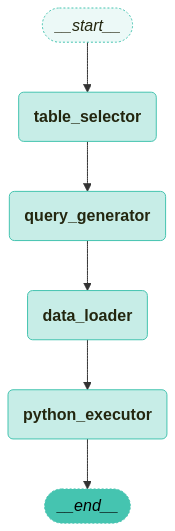

In [10]:
from langchain_teddynote.graphs import visualize_graph

builder = StateGraph(DBState)

builder.add_node("table_selector", table_selector_node)
builder.add_node("query_generator", query_generator_node)
builder.add_node("data_loader", data_loader_node)
builder.add_node("python_executor", python_executor_node)


builder.set_entry_point("table_selector")
builder.add_edge("table_selector", "query_generator")
builder.add_edge("query_generator", "data_loader")
builder.add_edge("data_loader", "python_executor")
builder.add_edge("python_executor", END)

graph = builder.compile()

visualize_graph(graph)

In [11]:
user_query = "3월 11일 원수 탁도의 평균을 시간대별로 알려줘."

initial_state = DBState(
    messages=[{"role": "user", "content": user_query}],
    question=user_query,
    conf=conf,
    dbm=dbm,
    db=db
)


result = graph.invoke(initial_state)



> Entering new AgentExecutor chain...

Invoking: `select_table` with `{'question': '3월 11일 원수 탁도의 평균을 시간대별로 알려줘.'}`


{'TB_C_RT': '시간대별 원수 탁도의 평균을 계산하기 위해 실시간 측정 데이터를 조회해야 합니다.', 'TB_TAG_MNG': '원수 탁도에 해당하는 태그 정보를 확인하기 위해 태그 관리 테이블을 조회해야 합니다.'}```json
{
    "TB_C_RT": "시간대별 원수 탁도의 평균을 계산하기 위해 실시간 측정 데이터를 조회해야 합니다.",
    "TB_TAG_MNG": "원수 탁도에 해당하는 태그 정보를 확인하기 위해 태그 관리 테이블을 조회해야 합니다."
}
```

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `generate_sql_query` with `{'question': '3월 11일 원수 탁도의 평균을 시간대별로 알려줘.', 'selected_tables': {'TB_C_RT': '시간대별 원수 탁도의 평균을 계산하기 위해 실시간 측정 데이터를 조회해야 합니다.', 'TB_TAG_MNG': '원수 탁도에 해당하는 태그 정보를 확인하기 위해 태그 관리 테이블을 조회해야 합니다.'}}`


{'TB_C_RT': "SELECT DATE_FORMAT(UPD_TI, '%Y-%m-%d %H:00:00') AS hour, AVG(CAST(TAG_VAL AS DECIMAL(10, 2))) AS average_turbidity\nFROM TB_C_RT\nWHERE TAG_SN IN (\n    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)\n    FROM TB_TAG_MNG\n    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%'\n)\nAND 

Failed to use model_dump to serialize <class '__main__.DBState'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pandas.core.frame.DataFrame'>)


```json
TB_C_RT: SELECT DATE_FORMAT(UPD_TI, '%Y-%m-%d %H:00:00') AS hour, AVG(CAST(TAG_VAL AS DECIMAL(10, 2))) AS average_turbidity
FROM TB_C_RT
WHERE TAG_SN IN (
    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)
    FROM TB_TAG_MNG
    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%'
)
AND UPD_TI >= '2025-03-11 00:00:00' AND UPD_TI < '2025-03-12 00:00:00'
GROUP BY hour
ORDER BY hour;, TB_TAG_MNG: SELECT * FROM TB_TAG_MNG WHERE AI_CD = 'C';
```

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to extract the March 11th data and calculate the average turbidity by hour from the 'TB_C_RT' dataframe.

Action: python_repl_tool
Action Input: 
```python
import pandas as pd

# Access the dataframe
df = df_dict['TB_C_RT']

# Convert the 'hour' column to datetime
df['hour'] = pd.to_datetime(df['hour'])

# Filter data for March 11th
march_11_data = df[df['hour'].dt.date == pd.to_datetime('2025-03-11').date()]

# Calculate the average turbidity by hour

Failed to use model_dump to serialize <class '__main__.DBState'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pandas.core.frame.DataFrame'>)


It seems there is a persistent issue with executing the code, likely due to a formatting or syntax error in the tool execution process. I will attempt to simplify the code and ensure it is correctly formatted for execution. Let's try executing a smaller portion of the code to identify the issue.

Action: python_repl_tool
Action Input: 
```python
# Let's try a simple print statement to check if the tool is working
print("Hello, World!")
```
Error: invalid syntax (<string>, line 1)

> Finished chain.
Agent stopped due to iteration limit or time limit.


In [1]:
print("SELECT *\nFROM TB_C_RT\nWHERE TAG_SN IN (\n    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)\n    FROM TB_TAG_MNG\n    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%'\n)\nAND UPD_TI >= '2025-04-30 00:00:00' AND UPD_TI < '2025-05-01 00:00:00'\nORDER BY UPD_TI DESC;")

SELECT *
FROM TB_C_RT
WHERE TAG_SN IN (
    SELECT SUBSTRING_INDEX(SUBSTRING_INDEX(TB_TAG_MNG.TAG_SN, '.', 2), '.', -1)
    FROM TB_TAG_MNG
    WHERE AI_CD = 'C' AND DP LIKE '%원수 탁도%'
)
AND UPD_TI >= '2025-04-30 00:00:00' AND UPD_TI < '2025-05-01 00:00:00'
ORDER BY UPD_TI DESC;
